# Setup

In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
voc_root = os.path.join(project_root, "data", "VOC2012")

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from data.voc_dataset import VOCDataset
from ssd.anchor import AnchorGenerator
from ssd.encoder import TargetEncoder
from ssd.box_utils import point_form, intersect, jaccard

In [3]:
dataset = VOCDataset('trainval', root=voc_root)
generator = AnchorGenerator()

In [4]:
img_tensor, bboxes = dataset[100]
img_tensor = img_tensor.permute(1, 2, 0).contiguous()
anchor_boxes = generator.anchor_boxes

print("Ground truth:", bboxes.shape)
for layer in anchor_boxes:
    print(f"{layer}: {anchor_boxes[layer].shape}")

Ground truth: torch.Size([2, 5])
Conv4_3: torch.Size([37, 37, 4, 4])
Conv7: torch.Size([18, 18, 6, 4])
Conv8_2: torch.Size([9, 9, 6, 4])
Conv9_2: torch.Size([5, 5, 6, 4])
Conv10_2: torch.Size([3, 3, 4, 4])
Conv11_2: torch.Size([1, 1, 4, 4])


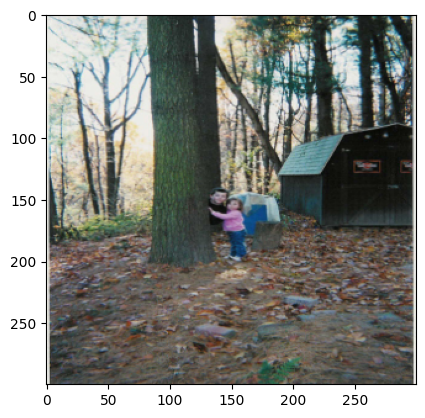

In [5]:
img = img_tensor.numpy() * 255
img = img.astype(np.uint8)
plt.imshow(img)

# Visualize Anchor Boxes Above IoU Threshold

In [6]:
priors = []
for layer in anchor_boxes:
    layer_priors = point_form(anchor_boxes[layer].view(-1, 4), clip=True)
    priors.append(layer_priors)
priors = torch.cat(priors, dim=0)    
print("Point form priors shape", priors.shape)

Point form priors shape torch.Size([8096, 4])


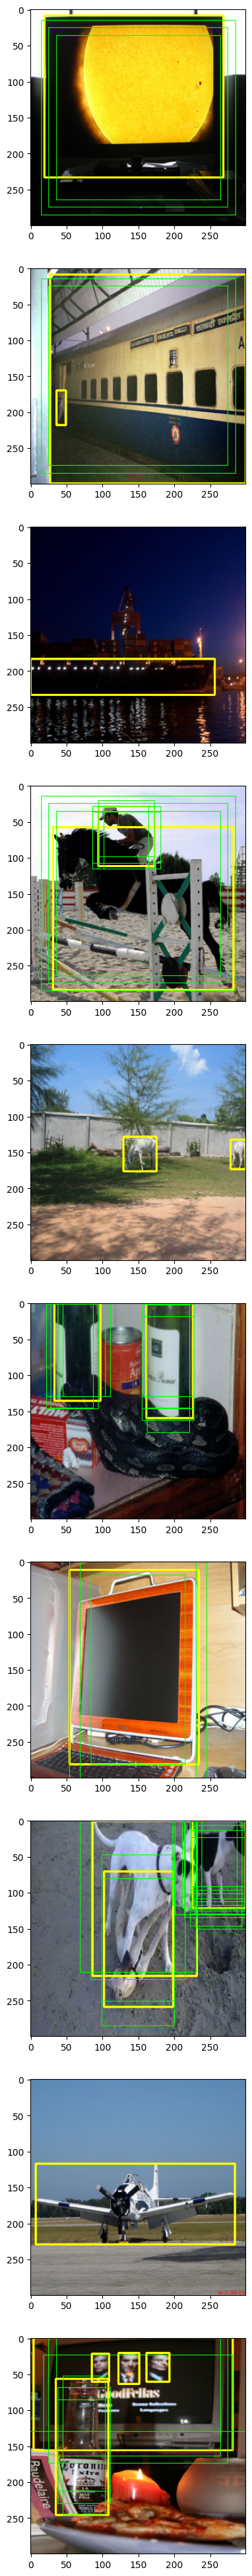

In [7]:
N = 10
iou_threshold = 0.70

fig, axs = plt.subplots(N, figsize=(5, 50))
for i in range(N):
    img_tensor, bboxes = dataset[i]
    img_tensor = img_tensor.permute(1, 2, 0).contiguous()

    img = img_tensor.numpy() * 255
    img = img.astype(np.uint8)
    height, width, _ = img.shape

    gt_boxes = bboxes[:, :4]    
    iou = jaccard(gt_boxes, priors)

    for j in range(iou.size(0)):
        gt_indices = torch.where(iou[j, :] > iou_threshold)
        xmin, ymin, xmax, ymax = gt_boxes[j]
        umin, vmin = int(xmin * width), int(ymin * height)
        umax, vmax = int(xmax * width), int(ymax * height)
        cv2.rectangle(img, (umin, vmin), (umax, vmax), color=(255, 255, 0), thickness=2)
        
        for bbox in priors[gt_indices]:
            xmin, ymin, xmax, ymax = bbox
            umin, vmin = int(xmin * width), int(ymin * height)
            umax, vmax = int(xmax * width), int(ymax * height)
            cv2.rectangle(img, (umin, vmin), (umax, vmax), color=(0, 255, 0), thickness=1)
            
    axs[i].imshow(img)

# Efficient IoU Calculation

We have `N` ground truth boxes and `M` priors. The objective is to compute a matrix of shape `(N, M)` where each element is an IoU score for `(gt_boxes[i], priors[j])`.

## Intersection

$$
\text{intersection} = (\min(x1_\max, x2_\max) - \max(x1_\min, x2_\min)) * (\min(y1_\max, y2_\max) - \max(y1_\min, y2_\min))
$$

First, reshape the tensors into 

```
gt_boxes: (N, 1, 2)
priors: (1, M, 2)
```

In [8]:
_, bboxes = dataset[4]
gt_boxes = bboxes[:, :4]    
print("Ground truth has shape", gt_boxes.shape)

N = gt_boxes.size(0)
M = priors.size(0)
print("Ground truth [min_x, min_y]", gt_boxes[:, :2].unsqueeze(1).shape)
print("Ground truth [max_x, max_y]", gt_boxes[:, 2:].unsqueeze(1).shape)
print("Priors [min_x, min_y]", priors[:, :2].unsqueeze(0).shape)
print("Priors [max_x, max_y]", priors[:, 2:].unsqueeze(0).shape)

Ground truth has shape torch.Size([2, 4])
Ground truth [min_x, min_y] torch.Size([2, 1, 2])
Ground truth [max_x, max_y] torch.Size([2, 1, 2])
Priors [min_x, min_y] torch.Size([1, 8096, 2])
Priors [max_x, max_y] torch.Size([1, 8096, 2])


Then broadcast the dimensions such that both of them are `(N, M, 2)`

In [9]:
gts_min_xy = gt_boxes[:, :2].unsqueeze(1).expand(N, M, 2)
gts_max_xy = gt_boxes[:, 2:].unsqueeze(1).expand(N, M, 2)
print("Ground truth [min_x, min_y]", gts_min_xy.shape)
print("Ground truth [max_x, max_y]", gts_max_xy.shape)

priors_min_xy = priors[:, :2].unsqueeze(0).expand(N, M, 2)
priors_max_xy = priors[:, 2:].unsqueeze(0).expand(N, M, 2)
print("Priors [min_x, min_y]", priors_min_xy.shape)
print("Priors [max_x, max_y]", priors_max_xy.shape)

Ground truth [min_x, min_y] torch.Size([2, 8096, 2])
Ground truth [max_x, max_y] torch.Size([2, 8096, 2])
Priors [min_x, min_y] torch.Size([2, 8096, 2])
Priors [max_x, max_y] torch.Size([2, 8096, 2])


In [10]:
intersect_width_height = torch.min(gts_max_xy, priors_max_xy) - torch.max(gts_min_xy, priors_min_xy)

The width and height can become negative, that also means they have zero intersection. It's better to simply clip the value.

In [11]:
intersect_width_height = intersect_width_height.clip(min=0)

In [12]:
intersection = intersect_width_height[:, :, 0] * intersect_width_height[:, :, 1]
intersection.size() # (N, M) is the desired size.

torch.Size([2, 8096])

## Area

Same concept here, we want to shape ground truth and prior in to `(N, M)`.

In [13]:
gts_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
print("Ground truth box areas", gts_area.size())
gts_area = gts_area.unsqueeze(1).expand(N, M)
print("Ground truth box areas", gts_area.size())

priors_area = (priors[:, 2] - priors[:, 0]) * (priors[:, 3] - priors[:, 1])
print("Prior box areas", priors_area.size())
priors_area = priors_area.unsqueeze(0).expand(N, M)
print("Prior box areas", priors_area.size())

Ground truth box areas torch.Size([2])
Ground truth box areas torch.Size([2, 8096])
Prior box areas torch.Size([8096])
Prior box areas torch.Size([2, 8096])


## IoU

In [14]:
iou = intersection / (gts_area + priors_area - intersection)
iou.shape

torch.Size([2, 8096])